In [1]:
import numpy as np
from matplotlib import pyplot as plt

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import optax  # https://github.com/deepmind/optax
import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping

In [2]:
from nn import Module, Network

In [3]:
# Hyperparameters

BATCH_SIZE = 100
LEARNING_RATE = 1e-3
STEPS = 1000
PRINT_EVERY = 30
SEED = 1234

In [4]:
normalise_data = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=True,
    download=True,
    transform=normalise_data,
)
test_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=False,
    download=True,
    transform=normalise_data,
)
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

In [13]:
layer1 = Module(
    eqx.nn.Linear(
        in_features=28*28,
        out_features=500,
        key=jr.PRNGKey(SEED)
    )
)
layer2 = Module(
    eqx.nn.Linear(
        in_features=500,
        out_features=500,
        key=jr.PRNGKey(SEED)
    )
)
layer3 = Module(
    eqx.nn.Linear(
        in_features=500,
        out_features=10,
        key=jr.PRNGKey(SEED)
    )
)

model = Network(
    [layer1, layer2, layer3],
    optax.adam(LEARNING_RATE)
)

print(model)

Network(
goodness: 0.0,
trainable layers: [0, 1, 2],
optimizer: GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x7fa88fdfb240>, update=<function chain.<locals>.update_fn at 0x7fa88fdfbc40>),
Layer 0: Module(
  _layer=Linear(
    weight=f32[500,784],
    bias=f32[500],
    in_features=784,
    out_features=500,
    use_bias=True
  ),
  _activation=<function <lambda>>,
  _goodness_fn=<function <lambda>>,
  _opt_state=None,
  _theta=2.0
),
Layer 1: Module(
  _layer=Linear(
    weight=f32[500,500],
    bias=f32[500],
    in_features=500,
    out_features=500,
    use_bias=True
  ),
  _activation=<function <lambda>>,
  _goodness_fn=<function <lambda>>,
  _opt_state=None,
  _theta=2.0
),
Layer 2: Module(
  _layer=Linear(
    weight=f32[10,500],
    bias=f32[10],
    in_features=500,
    out_features=10,
    use_bias=True
  ),
  _activation=<function <lambda>>,
  _goodness_fn=<function <lambda>>,
  _opt_state=None,
  _theta=2.0
),
)


In [6]:
dummy_x, dummy_y = next(iter(trainloader))
dummy_x = dummy_x.numpy()
dummy_y = dummy_y.numpy()
print(dummy_x.shape)  # BATCH_SIZEx1x28x28
print(dummy_y.shape)  # BATCH_SIZE

(100, 1, 28, 28)
(100,)


In [7]:
def overlay_y_on_x(x: Array, y: Array):
    """
    Replace the first 10 pixels of data [x] with one-hot-encoded label [y]
    """
    x_ = jnp.ravel(x)
    x_ = x_.at[:10].set(jax.nn.one_hot(y, 10))
    # x_ = x_.at[:10].set(jnp.zeros((10,)))
    # x_ = x_.at[y.item()].set(1)

    return x_.reshape(x.shape)

if BATCH_SIZE > 1:
    overlay_y_on_x = eqx.filter_vmap(overlay_y_on_x)

In [8]:
def permute_label(y: Array):
    return jax.random.permutation(jr.PRNGKey(SEED), y)

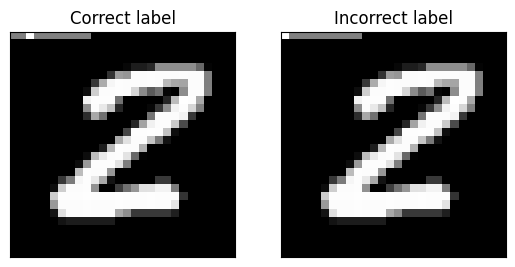

In [9]:
dummy_x_p = overlay_y_on_x(np.squeeze(dummy_x), dummy_y)
dummy_x_n = overlay_y_on_x(np.squeeze(dummy_x), permute_label(dummy_y))

if BATCH_SIZE > 1:
    show = (dummy_x_p[0], dummy_x_n[0])
else:
    show = (dummy_x_p, dummy_x_n)

ax = plt.subplot(1, 2, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(show[0], cmap='gray')
ax.set_title("Correct label")
ax = plt.subplot(1, 2, 2)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(show[1], cmap='gray')
ax.set_title("Incorrect label")
plt.show()

In [14]:
# train the first layer

losses = []
positive_gs = []
negative_gs = []

for i in range(STEPS):
    x, y = next(iter(trainloader))
    x = x.numpy()
    y = y.numpy()

    x_p = overlay_y_on_x(np.squeeze(x), y)
    x_n = overlay_y_on_x(np.squeeze(x), permute_label(y))

    if BATCH_SIZE > 1:
        x_p = jax.vmap(jnp.ravel)(x_p)
        x_n = jax.vmap(jnp.ravel)(x_n)

    loss, g_pos, g_neg = model.train_layer(
        0,
        x_p,
        x_n,
        batch = BATCH_SIZE > 1,
        batch_index=0
    )

    losses.append(loss)
    positive_gs.append(g_pos)
    negative_gs.append(g_neg)

    if i % PRINT_EVERY == 0:
        print(f"Step {i}: loss={loss:.4f}")

Step 0: loss=1.1269
Step 30: loss=1.1237
Step 60: loss=1.1123
Step 90: loss=1.0894
Step 120: loss=1.0552
Step 150: loss=1.0100
Step 180: loss=0.9613
Step 210: loss=0.9018
Step 240: loss=0.8503
Step 270: loss=0.7977
Step 300: loss=0.7576
Step 330: loss=0.7272
Step 360: loss=0.7109
Step 390: loss=0.7003
Step 420: loss=0.6972
Step 450: loss=0.6948
Step 480: loss=0.6933
Step 510: loss=0.6933
Step 540: loss=0.6931
Step 570: loss=0.6932
Step 600: loss=0.6932
Step 630: loss=0.6931
Step 660: loss=0.6932
Step 690: loss=0.6932
Step 720: loss=0.6931
Step 750: loss=0.6932
Step 780: loss=0.6931
Step 810: loss=0.6932
Step 840: loss=0.6931
Step 870: loss=0.6931
Step 900: loss=0.6931
Step 930: loss=0.6931
Step 960: loss=0.6931
Step 990: loss=0.6932


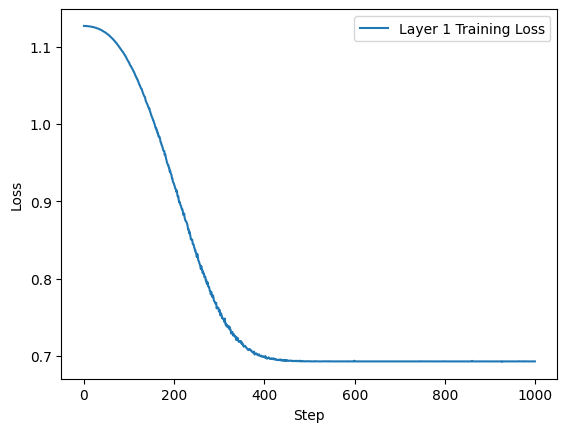

In [15]:
plt.plot(losses, label="Layer 1 Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
# train the second layer

losses_2 = []

for i in range(STEPS):
    x, y = next(iter(trainloader))
    x = x.numpy()
    y = y.numpy()

    x_p = overlay_y_on_x(np.squeeze(x), y)
    x_n = overlay_y_on_x(np.squeeze(x), permute_label(y))

    if BATCH_SIZE > 1:
        x_p = jax.vmap(jnp.ravel)(x_p)
        x_n = jax.vmap(jnp.ravel)(x_n)
    
    x_p = model.layers[0].forward(x_p)
    x_n = model.layers[0].forward(x_n)

    loss, g_pos, g_neg = model.train_layer(
        1,
        x_p,
        x_n,
        batch = BATCH_SIZE > 1,
        batch_index=0
    )

    losses_2.append(loss)

    if i % PRINT_EVERY == 0:
        print(f"Step {i}: loss={loss:.4f}")

Step 0: loss=1.1268
Step 30: loss=1.1248
Step 60: loss=1.1186
Step 90: loss=1.1068
Step 120: loss=1.0890
Step 150: loss=1.0654
Step 180: loss=1.0366
Step 210: loss=1.0035
Step 240: loss=0.9671
Step 270: loss=0.9285
Step 300: loss=0.8896
Step 330: loss=0.8515
Step 360: loss=0.8161
Step 390: loss=0.7847
Step 420: loss=0.7582
Step 450: loss=0.7370
Step 480: loss=0.7213
Step 510: loss=0.7102
Step 540: loss=0.7030
Step 570: loss=0.6985
Step 600: loss=0.6959
Step 630: loss=0.6945
Step 660: loss=0.6938
Step 690: loss=0.6934
Step 720: loss=0.6933
Step 750: loss=0.6932
Step 780: loss=0.6932
Step 810: loss=0.6932
Step 840: loss=0.6932
Step 870: loss=0.6932
Step 900: loss=0.6931
Step 930: loss=0.6931
Step 960: loss=0.6931
Step 990: loss=0.6931


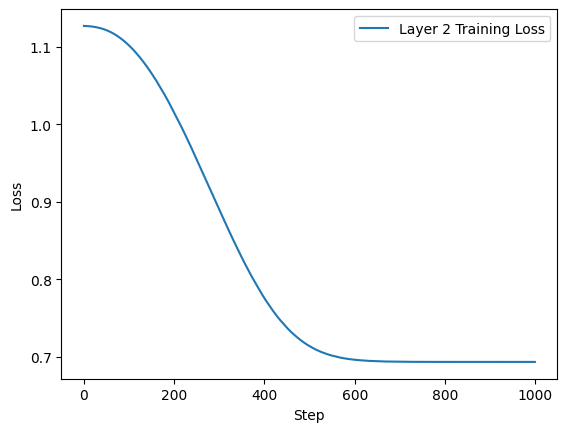

In [17]:
plt.plot(losses_2, label="Layer 2 Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
# Train the final layer

losses_3 = []

for i in range(STEPS):
    x, y = next(iter(trainloader))
    x = x.numpy()
    y = y.numpy()

    x_p = overlay_y_on_x(np.squeeze(x), y)
    x_n = overlay_y_on_x(np.squeeze(x), permute_label(y))

    if BATCH_SIZE > 1:
        x_p = jax.vmap(jnp.ravel)(x_p)
        x_n = jax.vmap(jnp.ravel)(x_n)
    
    x_p = model.layers[0].forward(x_p)
    x_p = model.layers[1].forward(x_p)

    x_n = model.layers[0].forward(x_n)
    x_n = model.layers[1].forward(x_n)

    loss, g_pos, g_neg = model.train_layer(
        2,
        x_p,
        x_n,
        batch = BATCH_SIZE > 1,
        batch_index=0
    )

    losses_3.append(loss)

    if i % PRINT_EVERY == 0:
        print(f"Step {i}: loss={loss:.4f}")

Step 0: loss=1.1268
Step 30: loss=1.1255
Step 60: loss=1.1218
Step 90: loss=1.1148
Step 120: loss=1.1044
Step 150: loss=1.0905
Step 180: loss=1.0732
Step 210: loss=1.0529
Step 240: loss=1.0299
Step 270: loss=1.0046
Step 300: loss=0.9775
Step 330: loss=0.9491
Step 360: loss=0.9200
Step 390: loss=0.8908
Step 420: loss=0.8623
Step 450: loss=0.8349
Step 480: loss=0.8094
Step 510: loss=0.7863
Step 540: loss=0.7660
Step 570: loss=0.7485
Step 600: loss=0.7341
Step 630: loss=0.7226
Step 660: loss=0.7137
Step 690: loss=0.7071
Step 720: loss=0.7023
Step 750: loss=0.6990
Step 780: loss=0.6968
Step 810: loss=0.6953
Step 840: loss=0.6945
Step 870: loss=0.6939
Step 900: loss=0.6936
Step 930: loss=0.6934
Step 960: loss=0.6933
Step 990: loss=0.6932


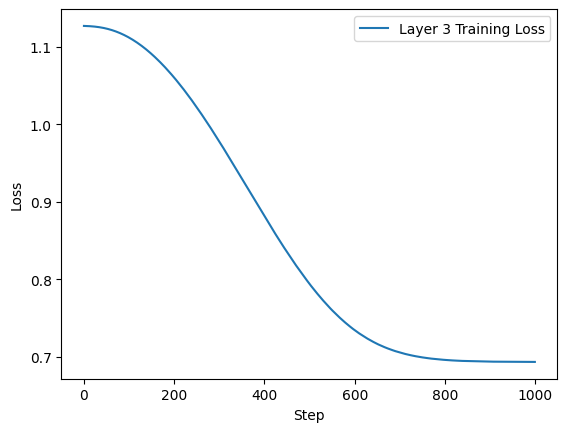

In [19]:
plt.plot(losses_3, label="Layer 3 Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [20]:
def predict(x: Array):
    goodness_per_label = []
    for label in range(10):
        x_ = overlay_y_on_x(x, np.array([label]))
        x_ = np.ravel(x_)
        x_ = np.expand_dims(x_, axis=0)
        goodness = 0.0
        for layer in model.layers:
            g = layer.goodness(x_)
            goodness += g
            x_ = layer.forward(x_)
        goodness_per_label.append(goodness.item())
    return np.argmax(goodness_per_label), goodness_per_label

Prediction: 1
Goodnesses: [228.68331909179688, 228.829345703125, 228.73895263671875, 228.74752807617188, 228.77499389648438, 228.75747680664062, 228.756591796875, 228.788330078125, 228.74700927734375, 228.78594970703125]


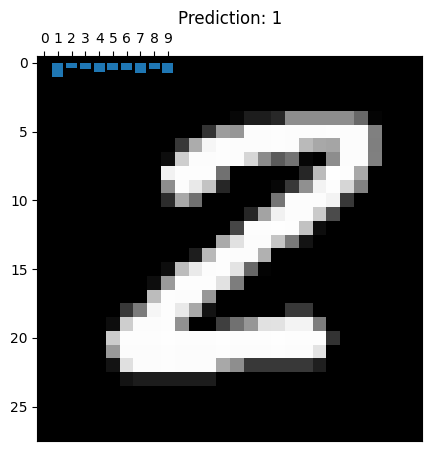

In [27]:
data = dummy_x[0]

prediction, goodnesses = predict(data)

print(f"Prediction: {prediction}")
print(f"Goodnesses: {goodnesses}")

# Normalize goodness values for better visualization
normalized_goodness = [(g - min(goodnesses)) / (max(goodnesses) - min(goodnesses)) for g in goodnesses]

plt.figure(figsize=(10, 5))
plt.bar(range(10), normalized_goodness)
plt.title('Goodness Score per Label')
plt.xticks(range(10))
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.imshow(np.squeeze(data), cmap='gray')
plt.title(f"Prediction: {prediction}")
plt.show()

In [48]:
goodnesses: list[list[float]] = []

for i in range(len(dummy_x)):
    data = dummy_x[i]
    prediction, goodness = predict(data)
    goodnesses.append(goodness)

goodnesses = np.array(goodnesses)
print(goodnesses.shape)

(100, 10)


In [49]:
# Set numpy print options to display 100 columns and 3 decimal places
np.set_printoptions(linewidth=100, precision=3, suppress=True)

print(f"{"Goodnesses Vector".center(81)} | Predicted Label")
print("=" * 100)
for g in goodnesses:
    print(f"{g} | {np.argmax(g)}")

                                Goodnesses Vector                                 | Predicted Label
[228.683 228.829 228.739 228.748 228.775 228.757 228.757 228.788 228.747 228.786] | 1
[251.494 251.662 251.558 251.568 251.6   251.58  251.579 251.615 251.567 251.612] | 1
[233.433 233.585 233.491 233.5   233.528 233.51  233.509 233.542 233.499 233.54 ] | 1
[248.413 248.577 248.475 248.485 248.516 248.496 248.495 248.531 248.485 248.528] | 1
[268.823 269.005 268.893 268.903 268.937 268.916 268.915 268.954 268.903 268.951] | 1
[259.477 259.652 259.544 259.554 259.587 259.566 259.565 259.603 259.553 259.6  ] | 1
[251.475 251.645 251.54  251.55  251.582 251.561 251.56  251.597 251.549 251.594] | 1
[263.938 264.115 264.005 264.016 264.049 264.028 264.027 264.065 264.015 264.062] | 1
[254.599 254.77  254.664 254.674 254.706 254.686 254.685 254.722 254.673 254.719] | 1
[242.319 242.479 242.38  242.389 242.419 242.4   242.399 242.434 242.389 242.431] | 1
[232.096 232.245 232.152 232.161 232.189

In [ ]:
# predict on test set

correct = 0
total = 0

for i, (x, y) in enumerate(testloader):
    print(i)
    x = x.numpy()
    y = y.numpy()

    print(x.shape)

    for i in range(len(x)):
        prediction, _ = predict(x[i])
        if prediction == y[i]:
            correct += 1
        total += 1

print(f"Accuracy: {correct/total:.4f}")